## Code to reproduce Figure S8

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os
import pickle
import cftime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.ticker import FixedLocator
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm, ListedColormap

In [2]:
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['legend.edgecolor']='black'
plt.rcParams['axes.linewidth']='0.8'
plt.rcParams['xtick.bottom']= 'True'
plt.rcParams['ytick.left']= 'True'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['xtick.major.size']='3.5'
plt.rcParams['ytick.major.size']='3.5'
plt.rcParams['xtick.major.width']='0.8'
plt.rcParams['ytick.major.width']='0.8'

plt.rc('font', size=13) # controls default text sizes          
plt.rc('axes', titlesize=13)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize

## Functions

In [3]:
EARTH_RADIUS = 6371000.0  # m

def estimate_bounds(points, bound_position=0.5):
    diffs = np.diff(points)
    diffs = np.concatenate(([diffs[0]], diffs, [diffs[-1]]))
    lower_bounds = points - diffs[:-1] * bound_position
    upper_bounds = points + diffs[1:] * (1 - bound_position)
    return np.column_stack((lower_bounds, upper_bounds))

def calculate_spherical_area(lat_bounds_rad, lon_bounds_rad, earth_radius):
    radius_sqr = earth_radius ** 2
    lat_bounds = lat_bounds_rad.astype(np.float64)
    lon_bounds = lon_bounds_rad.astype(np.float64)
    
    lat_diff = np.sin(lat_bounds[:, 1]) - np.sin(lat_bounds[:, 0])
    lon_diff = lon_bounds[:, 1] - lon_bounds[:, 0]
    
    areas = radius_sqr * np.outer(lat_diff, lon_diff)
    return np.abs(areas)

def calc_grid_cell_areas(longitudes, latitudes):
    lon_bounds_rad = np.deg2rad(estimate_bounds(longitudes))
    lat_bounds_rad = np.deg2rad(estimate_bounds(latitudes))
    
    areas = calculate_spherical_area(lat_bounds_rad, lon_bounds_rad, EARTH_RADIUS)
    return areas * 10000  # Convert m^2 to cm^2

In [4]:
def calc_NH_mean(df):

    conv_factor = 60*60*24*30 * 6.02e23 / 2.69e16 

    temp = df[:,:,96:120,:] 
    
    lon = temp.longitude.values
    lat = temp.latitude.values
    cell_area = calc_grid_cell_areas(lon, lat)
      
    temp2 = temp * conv_factor / cell_area # convert from flux (moles/s) to DU
    
    weights = np.cos(np.deg2rad(temp2.latitude[0:24]))
    weights.name = "weights"
    temp_w = temp2.weighted(weights)
    all_temp = temp_w.mean(dim=['latitude','longitude']) 
    all_ens = all_temp

    ens = all_ens.mean(dim='ensemble')

    return all_ens, ens

def calc_Arctic_mean(df):

    conv_factor = 60*60*24*30 * 6.02e23 / 2.69e16 

    temp = df[:,:,120:144,:] 
    
    lon = temp.longitude.values
    lat = temp.latitude.values
    cell_area = calc_grid_cell_areas(lon, lat)
      
    temp2 = temp * conv_factor / cell_area # convert from flux (moles/s) to DU
    
    weights = np.cos(np.deg2rad(temp2.latitude[0:24]))
    weights.name = "weights"
    temp_w = temp2.weighted(weights)
    all_temp = temp_w.mean(dim=['latitude','longitude']) 
    all_ens = all_temp

    ens = all_ens.mean(dim='ensemble')

    return all_ens, ens

def calc_ens_mean(df):
    mean_array = np.mean(df, axis = 0)
    return mean_array

In [7]:
def calc_cumulative_list_NH(data, varname, funcname):

    if varname == None:

        data_novolc, data_ens_novolc = funcname(data['novolc'])
        data_volc50_1, data_ens_volc50_1 = funcname(data['volc50_1'])
        data_volc50_2, data_ens_volc50_2 = funcname(data['volc50_2'])
        data_volc25, data_ens_volc25 = funcname(data['volc25'])
        data_volc98, data_ens_volc98 = funcname(data['volc98'])

    else:
        data_novolc, data_ens_novolc = funcname(data['novolc'][varname])
        data_volc50_1, data_ens_volc50_1 = funcname(data['volc50_1'][varname])
        data_volc50_2, data_ens_volc50_2 = funcname(data['volc50_2'][varname])
        data_volc25, data_ens_volc25 = funcname(data['volc25'][varname])
        data_volc98, data_ens_volc98 = funcname(data['volc98'][varname])

    list = [data_volc50_1, data_volc50_2, data_volc25, data_volc98] 
    list_ens = [data_ens_volc50_1, data_ens_volc50_2, data_ens_volc25, data_ens_volc98] 
    novolc_list = data_ens_novolc

    return list, list_ens, novolc_list

In [8]:
def superposed_epoch_NH(cycles):

    df_novolc = dataframe_novolc[cycles]
    data = data_all[cycles]
    data2 = data_ens[cycles]

    limit = 0.5
    df_eruptions2 = df_NHeruptions[(df_NHeruptions.NH_S_sulfur > limit) & (df_NHeruptions.Year < 2095)]

        
    selected_eruptions_year = {'volc50_1':list(df_eruptions2.Year[df_eruptions2.scenario == 'volc50_1'].values),
                            'volc50_2':list(df_eruptions2.Year[df_eruptions2.scenario == 'volc50_2'].values),
                            'volc25':list(df_eruptions2.Year[df_eruptions2.scenario == 'volc25'].values),
                            'volc98':list(df_eruptions2.Year[df_eruptions2.scenario == 'volc98'].values)}
    
    selected_eruptions_month = {'volc50_1':list(df_eruptions2.Month[df_eruptions2.scenario == 'volc50_1'].values),
                               'volc50_2':list(df_eruptions2.Month[df_eruptions2.scenario == 'volc50_2'].values),
                               'volc25':list(df_eruptions2.Month[df_eruptions2.scenario == 'volc25'].values),
                               'volc98':list(df_eruptions2.Month[df_eruptions2.scenario == 'volc98'].values)}
    
    dict_dataslice = {'volc50_1':{},'volc50_2':{},'volc25': {},'volc98':{}}

    i = 0 
    for scenario in dict_dataslice:
        for ens in range(3):
            df = data[i][ens,:]
            erup_year = selected_eruptions_year[scenario]
            erup_month = selected_eruptions_month[scenario]
            
            output = []
    
            for (y,m) in zip(erup_year, erup_month):
                # Calculate cumulative O3 loss for 12 months since eruption month
                all_ens = []
                novolc_ens = []
                for _ in range(85):
                    df_sum = df[m-1:m-1+12].sum(dim='time') # sum from eruption month for 12 months, skip first year
                    all_ens.append(df_sum)
    
                    df_sum_novolc = df_novolc[m-1:m-1+12].sum(dim='time') # sum from eruption month for 12 months, skip first year
                    novolc_ens.append(df_sum_novolc)
                    m = m + 12
                df_all = xr.concat(all_ens, dim='time')
                df_novolc_cumu = xr.concat(novolc_ens, dim='time')
                
                index = y-2015
                dataslice = df_all[index-2:index+6]
                dataslice_novolc = df_novolc_cumu[index-2:index+6]
                
                mean_before_erup = df_all[index-2:index].mean() - df_novolc_cumu[index-2:index].mean()
    
                anomaly = ((dataslice - dataslice_novolc).values - mean_before_erup.values)
    
                output.append(anomaly)
    
            dict_dataslice[scenario][ens] = output
        i = i+1


    dict_ens_dataslice = {'volc50_1':{},'volc50_2':{},'volc25': {},'volc98':{}}
    
    i = 0 
    for scenario in dict_ens_dataslice:
        df = data2[i][:]
        erup_year = selected_eruptions_year[scenario]
        erup_month = selected_eruptions_month[scenario]
        output = []
         
        for (y,m) in zip(erup_year, erup_month):
            # Calculate cumulative O3 loss for 12 months since eruption month
            all_ens = []
            novolc_ens = []
            for _ in range(85):
                df_sum = df[m-1:m-1+12].sum(dim='time') # sum from eruption month for 12 months, skip first year
                all_ens.append(df_sum)
    
                df_sum_novolc = df_novolc[m-1:m-1+12].sum(dim='time') # sum from eruption month for 12 months, skip first year
                novolc_ens.append(df_sum_novolc)
                m = m + 12
            df_all = xr.concat(all_ens, dim='time')
            df_novolc_cumu = xr.concat(novolc_ens, dim='time')
            
            index = y-2015
            dataslice = df_all[index-2:index+6]
            dataslice_novolc = df_novolc_cumu[index-2:index+6]
            mean_before_erup = df_all[index-2:index].mean() - df_novolc_cumu[index-2:index].mean()
    
            anomaly = ((dataslice - dataslice_novolc).values - mean_before_erup.values)
            output.append(anomaly)
    
        dict_ens_dataslice[scenario] = output
        i = i+1	


    array_concat =  dict_ens_dataslice['volc50_1'] + dict_ens_dataslice['volc50_2'] + dict_ens_dataslice['volc25'] + dict_ens_dataslice['volc98']

    ens_mean = calc_ens_mean(array_concat)
    
    all_array_concat = []
    for item in dict_dataslice:
        temp = dict_dataslice[item][0] + dict_dataslice[item][1] + dict_dataslice[item][2]
        all_array_concat = all_array_concat + temp
    
    mean = np.mean(all_array_concat, axis = 0)
    std = np.std(all_array_concat, axis = 0)
    q3 = np.quantile(all_array_concat, 0.75, axis = 0)
    q1 = np.quantile(all_array_concat, 0.25, axis = 0)

    return mean, q1, q3


In [9]:
def plot_composite(data, quantile1, quantile2, title, color, ax):

    year_index = [-2,-1,0,1,2,3,4,5]
    ax.plot(year_index, ens_mean, color = color, lw = 4)
    ax.fill_between(year_index, q1, q3, color = 'lightgrey', alpha = 0.5)

    ax.axvline(x = 0, color = 'k', ls = 'dotted', lw = 1)
    ax.axhline(y = 0, color = 'k', ls = 'dotted', lw = 1)
    
    ax.set_xlim(-2,5)
    ax.set_xlabel('Year since eruption', fontsize = 14)
    ax.set_ylabel('Ozone loss (DU)', fontsize = 14)

    ax.set_title(title, loc = 'right', fontsize = 14)

## Plot Figure S8

In [10]:
os.chdir('/gws/nopw/j04/vplume/mchim/netcdf_files/ozone_catalytic_cycles/sum_cycles/')

ssp370_run = {'novolc': [],'volc50_1': [],'volc50_2': [],'volc98': [],'volc25': []}

NOx_all = {}
ClOx_all = {}
HOx_all = {}
cycle_all = {}

for idx in ssp370_run:

    NOx_all[idx] = xr.open_dataset('_'+idx+'_sum_NOx_25km_allmonths.nc')
    ClOx_all[idx] = xr.open_dataset('_'+idx+'_sum_Cl_Br_25km_allmonths.nc')
    HOx_all[idx] = xr.open_dataset('_'+idx+'_sum_HOx_25km_allmonths.nc')
    cycle_all[idx] = NOx_all[idx].m01s50i117 + ClOx_all[idx].__xarray_dataarray_variable__ + HOx_all[idx].__xarray_dataarray_variable__

In [11]:
df_NHeruptions = pd.read_csv('/home/users/mmc70/Notebooks/Ozone_analysis/eruptions_relevant_for_ozone_NH.csv')

In [12]:
list_all, list_ens_all, novolc_list_all = calc_cumulative_list_NH(cycle_all, None, calc_Arctic_mean)
list_NOx, list_ens_NOx, novolc_list_NOx = calc_cumulative_list_NH(NOx_all, 'm01s50i117', calc_Arctic_mean)
list_halo, list_ens_halo, novolc_list_halo = calc_cumulative_list_NH(ClOx_all, '__xarray_dataarray_variable__', calc_Arctic_mean)
list_HOx, list_ens_HOx, novolc_list_HOx = calc_cumulative_list_NH(HOx_all, '__xarray_dataarray_variable__', calc_Arctic_mean)

data_all = {'halogen': list_halo,'HOx': list_HOx,'all':list_all,'NOx': list_NOx}
data_ens = {'halogen': list_ens_halo,'HOx': list_ens_HOx,'all':list_ens_all,'NOx':list_ens_NOx}
dataframe_novolc = {'all': novolc_list_all,'NOx': novolc_list_NOx,'halogen':novolc_list_halo,'HOx': novolc_list_HOx}

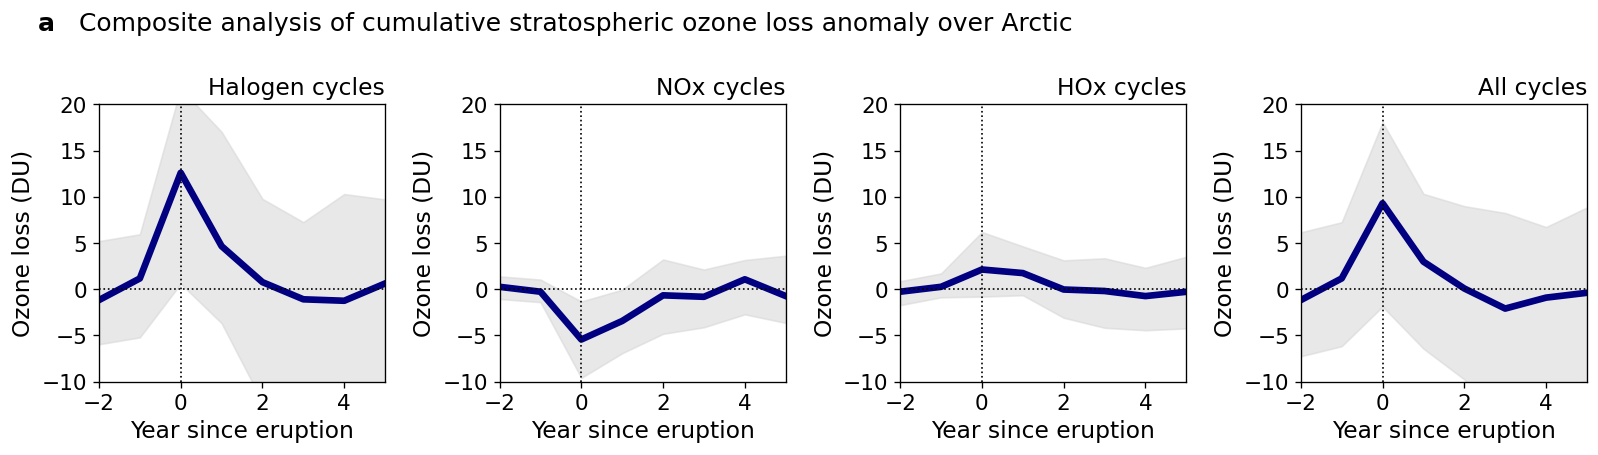

In [11]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(16, 3),dpi=120, gridspec_kw={'hspace': 0.4, 'wspace': 0.4})


ens_mean, q1, q3 = superposed_epoch_NH('halogen')
plot_composite(ens_mean, q1, q3, 'Halogen cycles', 'navy', ax=ax1)

ens_mean, q1, q3 = superposed_epoch_NH('NOx')
plot_composite(ens_mean, q1, q3, 'NOx cycles', 'navy', ax=ax2)

ens_mean, q1, q3 = superposed_epoch_NH('HOx')
plot_composite(ens_mean, q1, q3, 'HOx cycles', 'navy', ax=ax3)

ens_mean, q1, q3 = superposed_epoch_NH('all')
plot_composite(ens_mean, q1, q3, 'All cycles', 'navy', ax=ax4)

ax1.text(-3.5, 28, 'a', weight='bold', fontsize = 15)
ax1.text(-2.5, 28, 'Composite analysis of cumulative stratospheric ozone loss anomaly over Arctic', fontsize = 15)

for ax in (ax1,ax2,ax3,ax4):
    ax.set_ylim(-10,20)

In [12]:
list_all, list_ens_all, novolc_list_all = calc_cumulative_list_NH(cycle_all, None, calc_NH_mean)
list_NOx, list_ens_NOx, novolc_list_NOx = calc_cumulative_list_NH(NOx_all, 'm01s50i117', calc_NH_mean)
list_halo, list_ens_halo, novolc_list_halo = calc_cumulative_list_NH(ClOx_all, '__xarray_dataarray_variable__', calc_NH_mean)
list_HOx, list_ens_HOx, novolc_list_HOx = calc_cumulative_list_NH(HOx_all, '__xarray_dataarray_variable__', calc_NH_mean)

data_all = {'halogen': list_halo,'HOx':list_HOx,'all':list_all,'NOx':list_NOx}
data_ens = {'halogen': list_ens_halo,'HOx':list_ens_HOx,'all':list_ens_all,'NOx':list_ens_NOx}
dataframe_novolc = {'all': novolc_list_all,'NOx': novolc_list_NOx,'halogen':novolc_list_halo,'HOx': novolc_list_HOx}

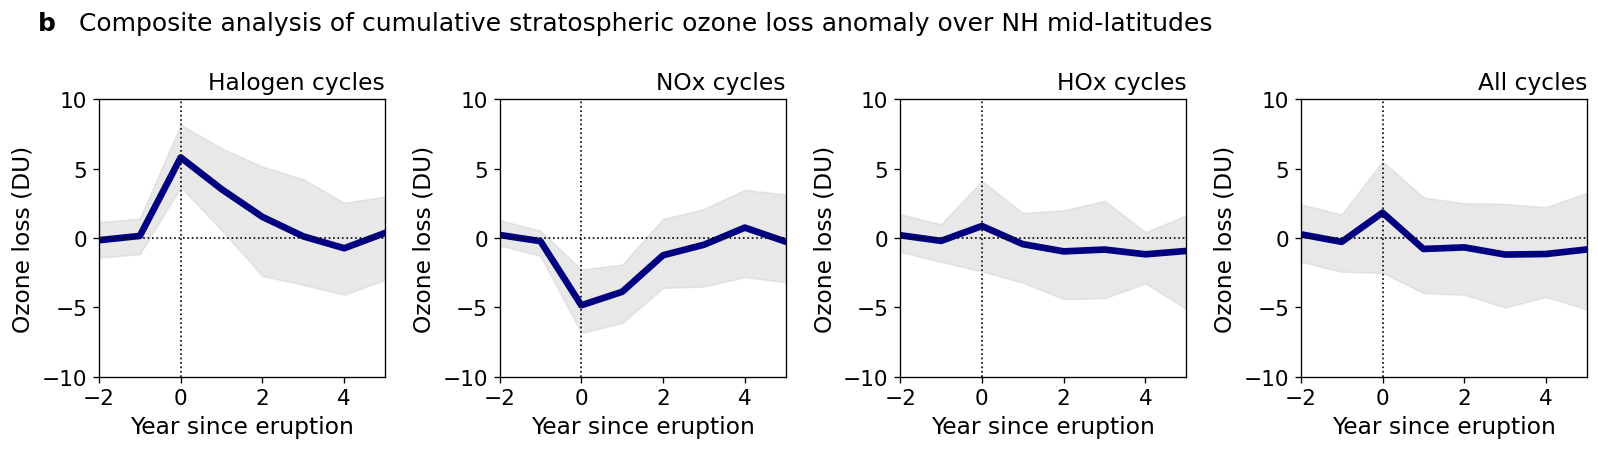

In [13]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(16, 3),dpi=120, gridspec_kw={'hspace': 0.4, 'wspace': 0.4})


ens_mean, q1, q3 = superposed_epoch_NH('halogen')
plot_composite(ens_mean, q1, q3, 'Halogen cycles', 'navy', ax=ax1)

ens_mean, q1, q3 = superposed_epoch_NH('NOx')
plot_composite(ens_mean, q1, q3, 'NOx cycles', 'navy', ax=ax2)

ens_mean, q1, q3 = superposed_epoch_NH('HOx')
plot_composite(ens_mean, q1, q3, 'HOx cycles', 'navy', ax=ax3)

ens_mean, q1, q3 = superposed_epoch_NH('all')
plot_composite(ens_mean, q1, q3, 'All cycles', 'navy', ax=ax4)

ax1.text(-3.5, 15, 'b', weight='bold', fontsize = 15)
ax1.text(-2.5, 15, 'Composite analysis of cumulative stratospheric ozone loss anomaly over NH mid-latitudes', fontsize = 15)

for ax in (ax1,ax2,ax3,ax4):
    ax.set_ylim(-10,10)